In [1]:
import pandas as pd
import re

DATA_PATH = 'datasets/cleaned_data.csv'
TEST_PATH = 'datasets/test_cleaned.csv'

data = pd.read_csv(DATA_PATH)
test = pd.read_csv(TEST_PATH)

In [2]:
data.shape, test.shape

((44878, 3), (20, 5))

In [2]:
def clean_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r"\\W"," ",text) # Remove non-word characters
    text = re.sub(r'https?://\S+|www\.\S+','',text) # Remove URLs
    text = re.sub('<.*?>+','',text) # Remove HTML tags
    return text

data['text'] = data['text'].apply(clean_text)
data['title'] = data['title'].apply(clean_text)

test['text'] = test['text'].apply(clean_text)
test['title'] = test['title'].apply(clean_text)

In [3]:
# Merge text and title into a single column
data['text'] = data['title'] + ' ' + data['text']
test['text'] = test['title'] + ' ' + test['text']

X = data['text']
Y = data['class']
X_test = test['text']
Y_test = test['class']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_val = vectorization.transform(x_val)

In [35]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(xv_train, y_train)
predictions = logistic_model.predict(xv_val)
print(classification_report(y_val, predictions))
print("Accuracy:", accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5807
           1       0.99      0.99      0.99      5413

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220

Accuracy: 0.9878787878787879


In [6]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(xv_train, y_train)
dt_pred = dt_model.predict(xv_val)
print("Decision Tree Classification Report:")
print(classification_report(y_val, dt_pred))
print(f"Accuracy: {accuracy_score(y_val, dt_pred)}\n")

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5807
           1       1.00      0.99      0.99      5413

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220

Accuracy: 0.9948306595365419



In [30]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(xv_train, y_train)
rf_pred = rf_model.predict(xv_val)
print("Random Forest Classification Report:")
print(classification_report(y_val, rf_pred))
print(f"Accuracy: {accuracy_score(y_val, rf_pred)}\n")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5807
           1       0.99      0.98      0.99      5413

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220

Accuracy: 0.9885918003565063



In [32]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(xv_train, y_train)
gbc_pred = gbc_model.predict(xv_val)
print("Gradient Boosting Classification Report:")
print(classification_report(y_val, gbc_pred))
print(f"Accuracy: {accuracy_score(y_val, gbc_pred)}\n")

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5807
           1       0.99      1.00      1.00      5413

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220

Accuracy: 0.995632798573975



In [7]:
# Support Vector Machine
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42, max_iter=1000, kernel='linear')
svm_model.fit(xv_train, y_train)
svm_pred = svm_model.predict(xv_val)
print("SVM Classification Report:")
print(classification_report(y_val, svm_pred))
print(f"Accuracy: {accuracy_score(y_val, svm_pred)}")

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5807
           1       1.00      0.99      1.00      5413

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220

Accuracy: 0.9951871657754011


In [13]:
import joblib
joblib.dump(svm_model, 'models/svm.joblib')
joblib.dump(vectorization, 'models/vectorization.joblib')

['models/vectorization.joblib']

In [12]:
# Test Predictions
xv_test = vectorization.transform(X_test)
test_predictions = svm_model.predict(xv_test)

## Conclusion
All in all, decision trees perform the best with the highest accuracy. However, SVMs is the fastest to train with the second highest accuracy. I will look at the decision tree and SVM below.

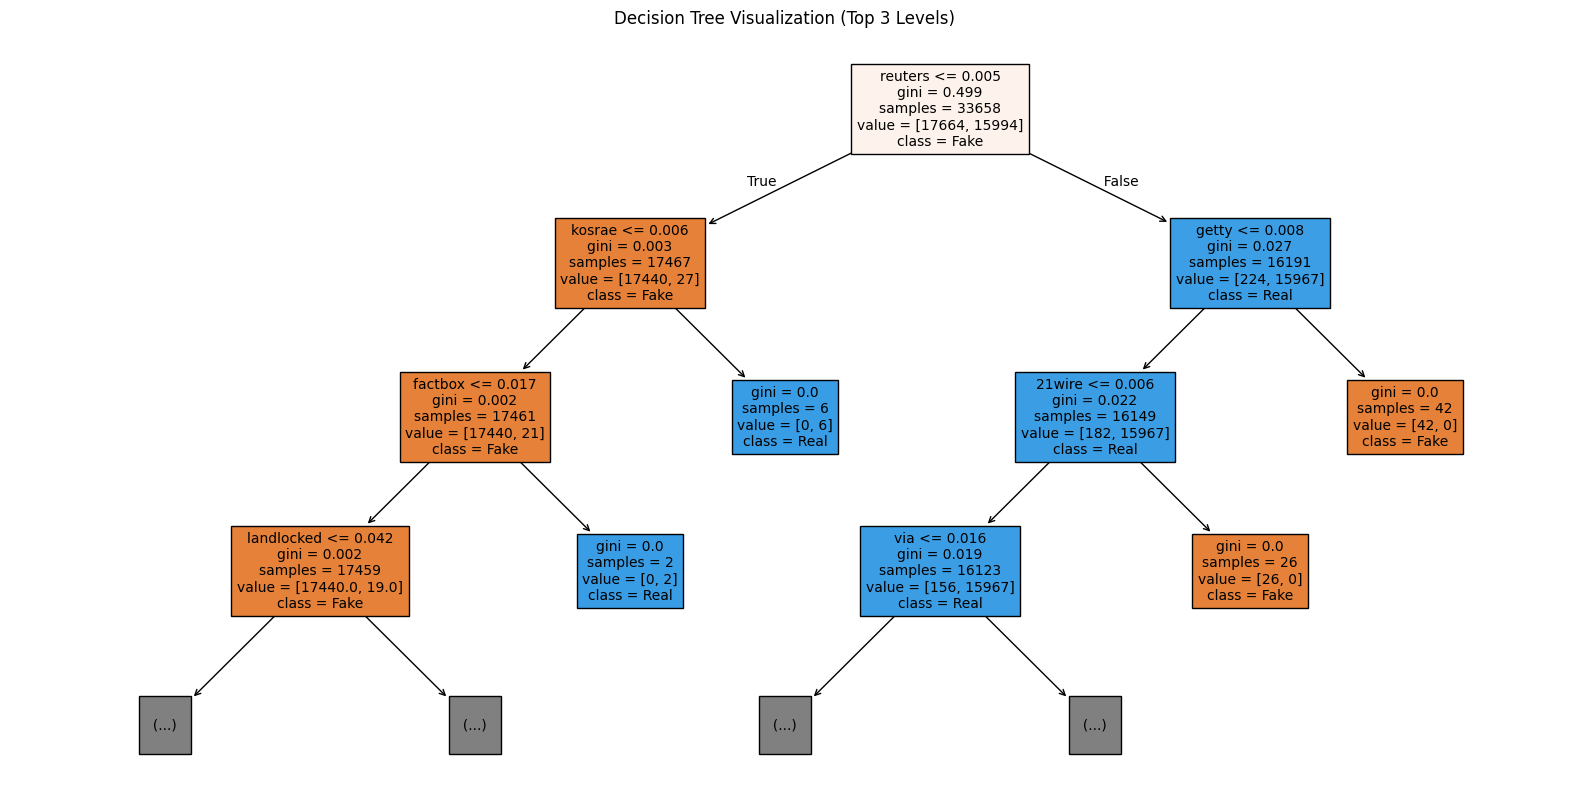

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          max_depth=3,  # Limit depth for readability
          feature_names=vectorization.get_feature_names_out(),
          class_names=['Fake', 'Real'],
          filled=True,
          fontsize=10)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature coefficients (weights) from SVM
feature_names = vectorization.get_feature_names_out()
coefficients = svm_model.coef_[0]  # Linear SVM has coef_ attribute

# Create DataFrame for analysis
svm_features_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("Top 20 Most Important Features (by absolute coefficient value):")
print(svm_features_df.head(20))

# Separate positive and negative coefficients
positive_features = svm_features_df[svm_features_df['coefficient'] > 0].head(15)
negative_features = svm_features_df[svm_features_df['coefficient'] < 0].head(15)

print(f"\nTop words indicating REAL news:")
for _, row in positive_features.iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")

print(f"\nTop words indicating FAKE news:")
for _, row in negative_features.iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")

Top 20 Most Important Features (by absolute coefficient value):
           feature  coefficient  abs_coefficient
80385      reuters    15.690611        15.690611
100376         via    -6.964320         6.964320
82775         said     6.638540         6.638540
100472       video    -4.410845         4.410845
78022         read    -4.198919         4.198919
68976           on     3.340711         3.340711
99367           us    -3.087983         3.087983
101728  washington     3.029769         3.029769
40991          gop    -3.008458         3.008458
17071     breaking    -2.873753         2.873753
44694      hillary    -2.648007         2.648007
51651         just    -2.627611         2.627611
36030     featured    -2.577689         2.577689
47036        image    -2.549449         2.549449
94366         this    -2.478273         2.478273
67578          nov     2.459015         2.459015
64014           mr    -2.414633         2.414633
79855   republican     2.372936         2.372936
84924